In [1]:
import trecs
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import nnls
from trecs.validate import validate_user_item_inputs
from collections import defaultdict

N.B. This notebook is tested for the `main` branch of `t-recs` as of 1/27/2021.

# Generate synthetic data

First, we generate all the user / item data that will be used in each of our simulations (including the social network, which is used in the social filtering model). All parameters are from the Chaney et al. paper (see https://arxiv.org/pdf/1710.11214.pdf).

In [2]:
def gen_social_network(user_prefs):
    """ Generates a |U|x|U| social network of connections
        as specified in Chaney et al.
    """
    user_cov = np.cov(user_prefs)
    possible_thresholds = np.sort(user_cov.flatten())[::-1]
    user_connections = None
    num_users = user_prefs.shape[0]
    for thresh in possible_thresholds[num_users:]:
        num_connected = (user_cov >= thresh).any(axis=1).sum()
        if num_connected == num_users:
            return (user_cov >= thresh).astype(int) # final adjacency matrix
    raise RuntimeError("Could not find a suitable threshold.")

    
def mu_sigma_to_alpha_beta(mu, sigma):
    """ For Chaney's custom Beta' function, we convert
        a mean and variance to an alpha and beta parameter
        of a Beta function. See footnote 3 page 3 of Chaney
        et al. for details.
    """
    alpha = ((1-mu) / (sigma**2) - (1/mu)) * mu**2
    beta = alpha * (1/mu - 1)
    return alpha, beta
    

# generate user vector
generator = np.random.default_rng()
# parameters from section 5 of paper
NUM_USERS = 100
NUM_ITEMS = 10000
NUM_ATTRS = 20
NUM_SIMS = 10

user_params = np.random.dirichlet(np.ones(NUM_ATTRS), size=NUM_SIMS) * 10
item_params = np.random.dirichlet(np.ones(NUM_ATTRS) * 100, size=NUM_SIMS) * 0.1
# do conversion from paper to fiure out the utility percentage visible to users
mu_n = 0.98  
sigma = 1e-5

# each element in users is the users vector in one simulation
users = []
items = []
true_utilities = []
known_util_perc = []
known_utils = []
social_networks = []
for sim_index in range(NUM_SIMS):
    # generate user preferences and item attributes
    user_prefs = np.random.dirichlet(user_params[sim_index, :], size=NUM_USERS) # 100 users
    item_attrs = np.random.dirichlet(item_params[sim_index, :], size=NUM_ITEMS) # 200 items
    
    # mean of the utility distribution
    true_utils_mu = user_prefs @ item_attrs.T
    true_utils_mu = np.clip(true_utils_mu, 1e-9, None) # avoid numerical stability issues
    # sample total utility from a beta distribution
    alphas, betas = mu_sigma_to_alpha_beta(true_utils_mu, sigma)
    true_utils = np.random.beta(alphas.flatten(), betas.flatten()).reshape((NUM_USERS, NUM_ITEMS))
    # assert support of true utilities; should be within 0 and 1
    assert true_utils.min() >= 0 and true_utils.max() <= 1
    
    # calculate known utility fo reach user
    alpha, beta = mu_sigma_to_alpha_beta(mu_n, sigma) # parameters for beta function governing percentage of utility known to users
    perc_known = np.random.beta(alpha, beta, size=(NUM_USERS, NUM_ITEMS))
    known_util = true_utils * perc_known 
    
    # add all synthetic data to list
    users.append(user_prefs) 
    social_networks.append(gen_social_network(user_prefs))
    items.append(item_attrs) 
    true_utilities.append(true_utils)
    known_util_perc.append(perc_known)
    known_utils.append(known_util)
    
    
# print shape
print(users[0].shape) # we should see 100 users with 20 attributes
print(items[0].shape) # we should see 1000 items with 20 attributes
print(true_utilities[0].shape)
print(known_utils[0].shape)

(100, 20)
(10000, 20)
(100, 10000)
(100, 10000)


Next, we visualize the true user utilities for each item  to verify that the resulting graph is similar to what appears in the Chaney paper.

Text(0.5, 1.0, 'True user-item utilities')

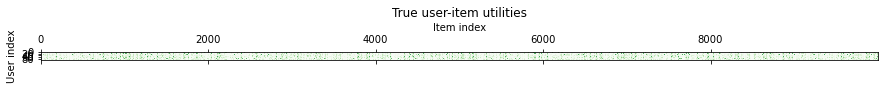

In [3]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(true_utilities[0], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('User index')
ax.set_title("True user-item utilities")
# this seems reasonably sparse and matches the picture in the Chaney paper! let's proceed

Text(0.5, 1.0, 'User-item utilities (known to user)')

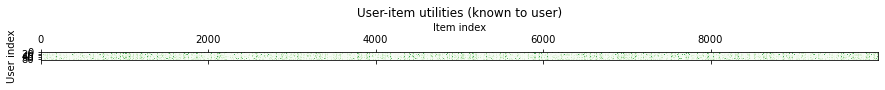

In [4]:
fig, ax = plt.subplots(figsize=(15,10))
ax.matshow(true_utilities[0] * known_util_perc[0], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('User index')
ax.set_title("User-item utilities (known to user)")

Text(0.5, 1.0, 'Item attributes of first 100 item')

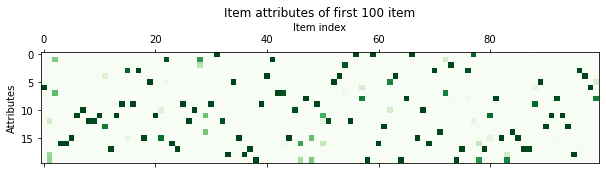

In [5]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow((items[0].T)[:, :100], cmap='Greens')
ax.set_xlabel('Item index')    
ax.xaxis.set_label_position('top') 
ax.set_ylabel('Attributes')
ax.set_title("Item attributes of first 100 item")

# Custom models/classes/metrics

Next, we create some custom models and metrics that will be used in our replication experiments. Most of the functionality is already in T-RECS, but we "customize" things here so we can measure the same things that Chaney measures. These include:
* Jaccard Similarity for pairs of similar users, where "similar" is defined by cosine similarity of model's internal user representation
* Ideal recommender system
* Random recommender system (randomly recommends items)
* Chaney content filtering system (updates internal representation of users by using `scipy.optimize.nnls` to solve for the least-squares approximation of user attributes)
* Custom content filtering system that "freezes" the model's internal representation of user attributes (important for the Jaccard Similarity metric mentioned earlier)

In [6]:
# necessary imports
from trecs.models import ContentFiltering, PopularityRecommender, ImplicitMF, SocialFiltering
from trecs.components import Users, Items, Creators
from trecs.metrics import HomogeneityMeasurement, InteractionSimilarity, Measurement
from trecs.matrix_ops import normalize_matrix, inner_product

from sklearn.metrics.pairwise import cosine_similarity

Custom score function that ensures that only the items in the training phase get recommended. The user must manually calculate how many items will be created & shown during the training period and pass this in as `max_items`.

In [7]:
def freeze_scores_after_n_items(max_items):
    """ This custom scoring function ensures that all items in the system
        that are created after a certain point are given a score of negative
        infinity, ensuring that they will be at the very bottom of any recommendation
        list.
    """
    def score_fn(users, items):
        predicted_scores = inner_product(users, items)
        # all predicted scores for these "new" items will be negative infinity,
        # ensuring they never get recommended
        predicted_scores[:, max_items:] = float('-inf')
        return predicted_scores
    return score_fn

def random_score_first_n_items(max_items):
    """ This custom scoring function ensures that all items in the system
        that are created after a certain point are given a score of negative
        infinity, ensuring that they will be at the very bottom of any recommendation
        list. It also ensures that the scores given to the first n items randomly
        change.
    """
    def score_fn(users, items):
        num_users = users.shape[0]
        num_items = items.shape[1]
        predicted_scores = np.random.rand(num_users, num_items)
        # all predicted scores for these "new" items will be negative infinity,
        # ensuring they never get recommended
        predicted_scores[:, max_items:] = float('-inf')
        return predicted_scores
    return score_fn

Custom interleaving method that ensures that all of the most recently created items (i.e., the newest items) are the ones interleaved with the recommendations.

In [8]:
def interleave_new_items(k, item_indices):
    """ Chooses the most recent, newest items to interleave
        with the recommendation set.
    """
    num_users = item_indices.shape[0]
    indices = item_indices[:, -k:]
    values = np.random.rand(*indices.shape)
    order = values.argsort(axis=1) # randomly sort indices within rows
    rows = np.tile(np.arange(num_users).reshape((-1, 1)), indices.shape[1])
    return indices[rows, order]

This custom "content creator" pumps out new items at every iteration. It starts with the full knowledge of all items at the beginning of the simulation, and then as the simulation progresses, "releases" new items to the RS.

In [9]:
class NewItemFactory(Creators):
    def __init__(self, items, items_per_iteration):
        """ Expects items in matrix of dimension |A| x |I|, where
            |A| is the number of attributes and |I| is the number
            of items.
        """
        self.items = items
        self.items_per_iteration = items_per_iteration
        self.idx = 0
        
    def generate_items(self):
        """ The items generated are simply selected from a particular
            range of indices, which gets incremented at each timestep.
        """
        if self.idx > self.items.shape[1]:
            raise RuntimeError("Ran out of items to generate!")
        idx_start = self.idx
        idx_end = self.idx + self.items_per_iteration
        self.idx = idx_end
        return self.items[:, idx_start:idx_end]

This special subclass of `Users` allows users to know their true scores for all items (even those that haven't been created yet).

In [10]:
class ChaneyUsers(Users):
    def __init__(self, true_scores, *args, **kwargs):
        self.true_scores = np.copy(true_scores) # contains all user-item scores
        super().__init__(*args, **kwargs)
        
    def compute_user_scores(self, items):
        """ No need to do this at initialization - user will be set with scores later.
        """
        self.actual_user_scores = self.true_scores
        
    def score_new_items(self, items):
        """ Chaney users are special - they already know all their
            utility values for all items
        """
        pass
    
    def get_user_feedback(self, *args, **kwargs):
        interactions = super().get_user_feedback(*args, **kwargs)
        return interactions

Custom measurement that measures the Jaccard index of interactions between pairs of users, relative to the ideal recommender.

In [11]:
class InteractionTracker(Measurement):
    """ Tracks all user interactions up to the current timepoint. In the context of replication,
        it will be used to track homogenization of the ideal recommender system.
    """
    def __init__(self, name="interaction_history", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        interactions = kwargs.pop("interactions", None)
        self.observe(np.copy(interactions).reshape((-1, 1)))

        
def calculate_avg_jaccard(pairs, interactions):
    """ Calculates average Jaccard index over specified pairs of users.
    """
    similarity = 0
    num_pairs = len(pairs)
    for user1, user2 in pairs:
        itemset_1 = set(interactions[user1, :])
        itemset_2 = set(interactions[user2, :])
        common = len(itemset_1.intersection(itemset_2))
        union = len(itemset_1.union(itemset_2))
        similarity += common / union / num_pairs
    return similarity
        
class SimilarUserInteractionSimilarity(Measurement):
    def __init__(self, ideal_interaction_hist, name="similar_user_jaccard", verbose=False):
        self.ideal_hist = ideal_interaction_hist
        self.interaction_hist = None
        self.timestep = 0
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        interactions = kwargs.pop("interactions", None)
        if interactions is None:
            raise ValueError(
                "interactions must be passed in to InteractionSimilarity's `measure` "
                "method as a keyword argument"
            )
        if self.interaction_hist is None:
            self.interaction_hist = np.copy(interactions).reshape((-1, 1))
        else:
            self.interaction_hist = np.hstack([self.interaction_hist, interactions.reshape((-1, 1))])
        # generate cosine similarity matrix for all users
        assert recommender.users_hat.get_timesteps() == self.timestep + 1 # ensure that the users_hat variable is storing copies at each timestep
        user_representation = recommender.users_hat.state_history[-1]
        sim_matrix = cosine_similarity(user_representation, user_representation)
        # set diagonal entries to zero
        num_users = sim_matrix.shape[0]
        sim_matrix[np.arange(num_users), np.arange(num_users)] = 0
        # array where element x at index i represents the "most similar" user to user i
        closest_users = np.argmax(sim_matrix, axis=1)
        pairs = list(enumerate(closest_users))
        # calculate average jaccard similarity
        ideal_similarity = calculate_avg_jaccard(pairs, self.ideal_hist[:, :(self.timestep + 1)]) # compare
        this_similarity = calculate_avg_jaccard(pairs, self.interaction_hist)
        self.observe(this_similarity - ideal_similarity)
        self.timestep += 1 # increment timestep

In [12]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass
    
    def process_new_items(self, new_items):
        """
        Generate zero attributes for new items. Remember,
        this doesn't actually matter because the IdealRecommender
        uses its perfect score function, not
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = np.random.rand(num_attr, num_items)
        return item_representation
    
def perfect_scores_first_items(max_items, true_scores):
    """ This custom scoring function ensures that all items in the system
        that are created after a certain point are given a score of negative
        infinity, ensuring that they will be at the very bottom of any recommendation
        list. Otherwise, we return the "true scores" specified in the
        true_scores array.
    """
    score_copy = np.copy(true_scores)
    def score_fn(users, items):
        predicted_scores = np.copy(score_copy)
        num_users, num_items = users.shape[0], items.shape[1]
        # all predicted scores for these "new" items will be negative infinity,
        # ensuring they never get recommended
        predicted_scores = predicted_scores[:num_users, :num_items] # subset to correct dimensions
        predicted_scores[:, max_items:] = float('-inf')
        return predicted_scores
    return score_fn

In [13]:
# example usage of ideal recommender
true_prefs = users[0] # underlying true preferences
true_scores = true_utilities[0]
noisy_scores = known_utils[0]

u = Users(actual_user_scores = noisy_scores, size=(NUM_USERS, NUM_ATTRS), num_users=NUM_USERS) # each user interacts with items based on their (noisy) knowledge of their own scores
ideal_rec = IdealRecommender(item_representation=items[0].T, actual_user_representation=u, score_fn=perfect_scores_first_items(10000, true_scores))
ideal_rec.startup_and_train(timesteps=10)
ideal_rec.run(
    timesteps=10,
    train_between_steps=False, 
    random_items_per_iter=ideal_rec.num_items_per_iter, 
    vary_random_items_per_iter=True
)

# run some sanity checks to ensure that nothing was altered during simulation
np.testing.assert_array_equal(u.actual_user_scores, noisy_scores)
# check that actual user scores as a percentage of the true utilities
# is the same as the known util percentages
np.testing.assert_array_equal(true_scores, ideal_rec.predicted_scores)

100%|██████████| 10/10 [00:00<00:00, 60.70it/s]


In [14]:
# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        self.items_hat[:, :] = np.random.rand(*self.items_hat.shape)
        self.users_hat[:, :] = np.random.rand(*self.users_hat.shape)
        
    def process_new_items(self, new_items):
        """
        Generate random attributes for new items.
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = np.random.rand(num_attr, num_items)
        return item_representation

In [15]:
# Chaney ContentFiltering - uses NNLS solver
class ChaneyContent(ContentFiltering):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def _update_internal_state(self, interactions):
        # update cumulative interactions
        num_new_items = self.items_hat.shape[1] - self.cumulative_interactions.shape[1] # how many new items were added to the system?
        if num_new_items > 0:
            self.cumulative_interactions = np.hstack([self.cumulative_interactions, np.zeros((self.num_users, num_new_items))]) # add new items to cumulative interactions
        self.cumulative_interactions[self.users.user_vector, interactions] += 1
        
    def train(self):
        if hasattr(self, 'cumulative_interactions') and self.cumulative_interactions.sum() > 0: # if there are interactions present:
            items_to_train = self.cumulative_interactions.shape[1] # can't train representations for new items before interactions have happened!
            for i in range(self.num_users):
                item_attr = self.items_hat[:, :items_to_train].T
                self.users_hat[i, :] = nnls(item_attr, self.cumulative_interactions[i, :])[0] # solve for Content Filtering representation using nnls solver
            num_new_items = self.items_hat.shape[1] - self.cumulative_interactions.shape[1] # how many new items were added to the system?
            
        else:
            self.cumulative_interactions = np.zeros((self.users_hat.shape[0], self.items_hat.shape[1]))
        super().train()
        

In [16]:
# utility function to extract measurement
def process_measurement(model, metric_string):
    return model.get_measurements()[metric_string][1:]

# Repeated Training

Now, we actually run the recommender system models on the synthetic datasets. After each model finishes running, we extract two measures of homogenization (change in Jaccard index averaged over pairs of users that are randomly chosen, and the change in Jaccard index averaged over pairs of users that are most similar to each other by cosine similarity).

Note that this is the "repeated training" case, where algorithms are repeatedly updated with new data at each iteration. 

In [17]:
STARTUP_ITERS = 10
SIM_ITERS = 90
NEW_ITEMS_PER_ITER = 10
TOTAL_ITEMS_IN_STARTUP = NEW_ITEMS_PER_ITER * STARTUP_ITERS
ATTENTION_EXP = -0.8 # from Chaney paper, attention function is f(n) = n^(-0.8)

# simpler way to pass common arguments
init_params = {
    "num_items_per_iter": NEW_ITEMS_PER_ITER,
    "num_users": NUM_USERS,
    "num_items": 0, # all simulations start with 0 items
    "interleaving_fn": interleave_new_items
}

run_params = {
    "random_items_per_iter": NEW_ITEMS_PER_ITER,
    "vary_random_items_per_iter": False,
}

def initialize_users_and_items(known_scores, all_items):
    # each user interacts with items based on their (noisy) knowledge of their own scores
    # user choices also depend on the order of items they are recommended
    u = ChaneyUsers(np.copy(known_scores), size=(NUM_USERS, NUM_ATTRS), num_users=NUM_USERS, attention_exp=ATTENTION_EXP, repeat_items=False)
    item_factory = NewItemFactory(np.copy(all_items), NEW_ITEMS_PER_ITER)
    empty_item_set = np.array([]).reshape((NUM_ATTRS, 0)) # initialize empty item set
    return u, item_factory, empty_item_set


def run_ideal_sim(user_prefs, item_attrs, true_utilities, noisy_utilities, pairs, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    ideal = IdealRecommender(
        user_representation=user_prefs,
        creators=item_factory, 
        actual_user_representation=u,
        actual_item_representation=empty_items,
        score_fn=perfect_scores_first_items(TOTAL_ITEMS_IN_STARTUP, true_utilities),
        **init_params
    )
    ideal.add_metrics(InteractionSimilarity(pairs), InteractionTracker())
    ideal.startup_and_train(timesteps=STARTUP_ITERS)
    ideal.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER) # show all items from training set plus interleaved itmes
    ideal.run(timesteps=SIM_ITERS, **run_params)
    return ideal

def run_content_sim(item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    chaney = ChaneyContent(
        creators=item_factory, 
        num_attributes=NUM_ATTRS, 
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=freeze_scores_after_n_items(TOTAL_ITEMS_IN_STARTUP),
        **init_params)
    chaney.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity(ideal_interactions, verbose=True))
    chaney.add_state_variable(chaney.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    chaney.startup_and_train(timesteps=STARTUP_ITERS) # update user representations, but only serve random items
    chaney.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER) # show all items from training set plus interleaved itmes
    chaney.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    return chaney
    
def run_mf_sim(item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    mf = ImplicitMF(
        creators=item_factory,
        actual_item_representation=empty_items, 
        actual_user_representation=u, 
        score_fn=freeze_scores_after_n_items(TOTAL_ITEMS_IN_STARTUP),
        verbose=True,
        **init_params
    )
    mf.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity(ideal_interactions))
    mf.add_state_variable(mf.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    mf.startup_and_train(timesteps=STARTUP_ITERS, no_new_items=False) # update user representations, but only serve random items
    mf.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER) # show all items from training set plus interleaved itmes
    mf.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, reset_interactions=False, **run_params)
    return mf
    
    
def run_sf_sim(social_network, item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    sf = SocialFiltering(
        creators=item_factory,
        user_representation=social_network, 
        actual_item_representation=empty_items, 
        actual_user_representation=u,
        score_fn=freeze_scores_after_n_items(TOTAL_ITEMS_IN_STARTUP),
        **init_params
    )
    sf.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity(ideal_interactions))
    sf.add_state_variable(sf.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    sf.startup_and_train(timesteps=STARTUP_ITERS)
    sf.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER) # show all items from training set plus interleaved itmes
    sf.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    return sf

def run_pop_sim(item_attrs, noisy_utilities, pairs, ideal_interactions, repeated_training):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    p = PopularityRecommender(
        creators=item_factory,
        actual_item_representation=empty_items, 
        actual_user_representation=u, 
        score_fn=freeze_scores_after_n_items(TOTAL_ITEMS_IN_STARTUP),
        **init_params
    )
    p.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity(ideal_interactions))
    p.add_state_variable(p.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    p.startup_and_train(timesteps=STARTUP_ITERS)
    p.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER)
    p.run(timesteps=SIM_ITERS, train_between_steps=repeated_training, **run_params)
    return p
    
def run_random_sim(item_attrs, noisy_utilities, pairs, ideal_interactions):
    u, item_factory, empty_items = initialize_users_and_items(noisy_utilities, item_attrs)
    r = RandomRecommender(
        creators=item_factory,
        num_attributes=NUM_ATTRS,
        actual_item_representation=empty_items, 
        actual_user_representation=u, 
        score_fn=random_score_first_n_items(TOTAL_ITEMS_IN_STARTUP),
        **init_params
    )
    r.add_metrics(InteractionSimilarity(pairs), SimilarUserInteractionSimilarity(ideal_interactions)) # random pairing of users
    r.add_state_variable(r.users_hat) # need to do this so that the similarity metric uses the user representation from before interactions were trained
    r.startup_and_train(timesteps=STARTUP_ITERS)
    r.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER)
    r.run(timesteps=SIM_ITERS, train_between_steps=True, **run_params)
    return r

In [18]:
model_keys = ["ideal", "content_chaney", "mf", "sf", "popularity", "random"]
# stores results for each type of model for each type of user pairing (random or cosine similarity)
rep_train_results = {"sim_users": defaultdict(list), "random_users": defaultdict(list)}
rep_train_models = {}

for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utilities[i]
    noisy_scores = known_utils[i]
    item_representation = items[i].T
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [np.random.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
    
    repeated_training = True
    rep_train_models["ideal"] = run_ideal_sim(true_prefs, item_representation, true_scores, noisy_scores, pairs, repeated_training)
    ideal_interactions = np.hstack(process_measurement(rep_train_models["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    rep_train_models["content_chaney"] = run_content_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    rep_train_models["mf"] = run_mf_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    rep_train_models["sf"] = run_sf_sim(social_network, item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    rep_train_models["popularity"] = run_pop_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    rep_train_models["random"] = run_random_sim(item_representation, noisy_scores, pairs, ideal_interactions)
    
    # extract results from each model
    for model_key in model_keys:
        model = rep_train_models[model_key]
        rep_train_results["random_users"][model_key].append(process_measurement(model, "interaction_similarity"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            rep_train_results["sim_users"][model_key].append(process_measurement(model, "similar_user_jaccard"))

100%|██████████| 10/10 [00:00<00:00, 32.80it/s]
/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 10/10 [00:00<00:00, 24.41it/s]
/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 10/10 [00:00<00:00, 25.00it/s]
/mnt/c/Users/matth/pton-research/recsys/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this ov

In [19]:
# graphing
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 14})

# smoothing factor for visualizing curves
sigma = 1

## Change in Jaccard (users paired randomly)

In [20]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(rep_train_results["random_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(rep_train_results["random_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

In [21]:
# readable legend keys
id_to_readable = {
    "ideal": "ideal", 
    "content_chaney": "content (Chaney et al.)",
    "mf" : "matrix factorization",
    "sf": "social filtering",
    "popularity": "popularity", 
    "random": "random"
}

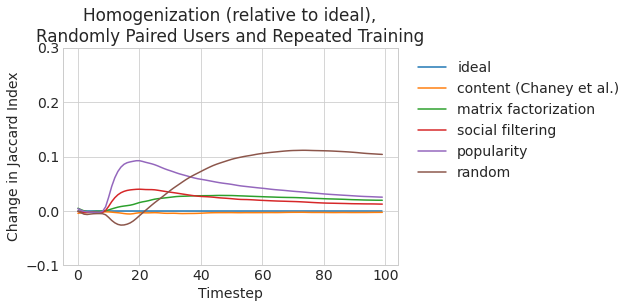

In [22]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.3)
plt.title("Homogenization (relative to ideal),\nRandomly Paired Users and Repeated Training")
plt.savefig('repeated_training_random_pair.pdf', bbox_inches = "tight")

## Change in Jaccard (similar users paired)

In [23]:
# get change in jaccard index just for ideal recommender
relative_jaccard = {}
relative_jaccard["ideal"] = np.zeros(STARTUP_ITERS + SIM_ITERS)

for model_key in model_keys:
    if model_key is not "ideal":
        relative_jaccard[model_key] = (np.array(rep_train_results["sim_users"][model_key])).mean(axis=0) # average across 10 trials

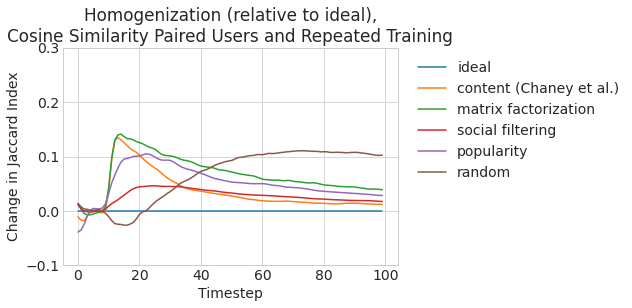

In [24]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.3)
plt.title("Homogenization (relative to ideal),\nCosine Similarity Paired Users and Repeated Training")
plt.savefig('repeated_training_sim_pair.pdf', bbox_inches = "tight")

# Single training

We do the same training with all of the same models just as we did earlier, but now we only train each model once - following the startup phase.

In [25]:
# stores results for each type of model for each type of user pairing (random or cosine similarity)
single_train_results = {"sim_users": defaultdict(list), "random_users": defaultdict(list)}

STARTUP_ITERS = 50
SIM_ITERS = 50

for i in range(NUM_SIMS):
    true_prefs = users[i] # underlying true preferences
    true_scores = true_utilities[i]
    noisy_scores = known_utils[i]
    item_representation = items[i].T
    social_network = social_networks[i]

    # generate random pairs for evaluating jaccard similarity
    pairs = [np.random.choice(NUM_USERS, 2, replace=False) for _ in range(800)]
    
    repeated_training = False
    single_train_results["ideal"] = run_ideal_sim(true_prefs, item_representation, true_scores, noisy_scores, pairs, repeated_training)
    ideal_interactions = np.hstack(process_measurement(single_train_results["ideal"], "interaction_history")) # pull out the interaction history for the ideal simulations
    single_train_results["content_chaney"] = run_content_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    single_train_results["mf"] = run_mf_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    single_train_results["sf"] = run_sf_sim(social_network, item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    single_train_results["popularity"] = run_pop_sim(item_representation, noisy_scores, pairs, ideal_interactions, repeated_training)
    single_train_results["random"] = run_random_sim(item_representation, noisy_scores, pairs, ideal_interactions)
    
    # extract results from each model
    for model_key in model_keys:
        model = single_train_results[model_key]
        single_train_results["random_users"][model_key].append(process_measurement(model, "interaction_similarity"))
        if model_key is not "ideal": # homogenization of similar users is always measured relative to the ideal model
            single_train_results["sim_users"][model_key].append(process_measurement(model, "similar_user_jaccard"))

100%|██████████| 50/50 [00:02<00:00, 22.41it/s]


## Change in Jaccard (users paired randomly)

In [26]:
# get change in jaccard index just for ideal recommender
ideal_jaccard = np.array(single_train_results["random_users"]["ideal"])
relative_jaccard = {}

for model_key in model_keys:
    abs_jaccard = np.array(single_train_results["random_users"][model_key])
    relative_jaccard[model_key] = (abs_jaccard - ideal_jaccard).mean(axis=0) # average across 10 trials

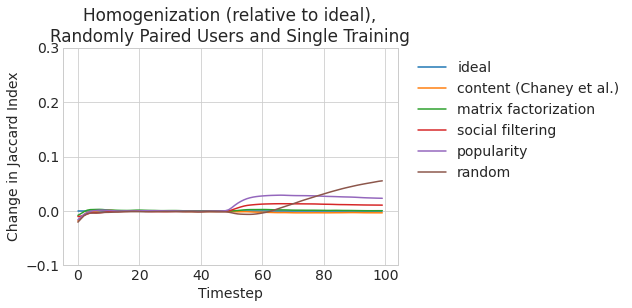

In [27]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.ylim(-0.1, 0.3)
plt.title("Homogenization (relative to ideal),\nRandomly Paired Users and Single Training")
plt.savefig('single_training_random_pair.pdf', bbox_inches = "tight")

## Change in Jaccard (similar users paired)

In [28]:
# get change in jaccard index just for ideal recommender
relative_jaccard = {}
relative_jaccard["ideal"] = np.zeros(STARTUP_ITERS + SIM_ITERS)

for model_key in model_keys:
    if model_key is not "ideal":
        relative_jaccard[model_key] = (np.array(single_train_results["sim_users"][model_key])).mean(axis=0) # average across 10 trials

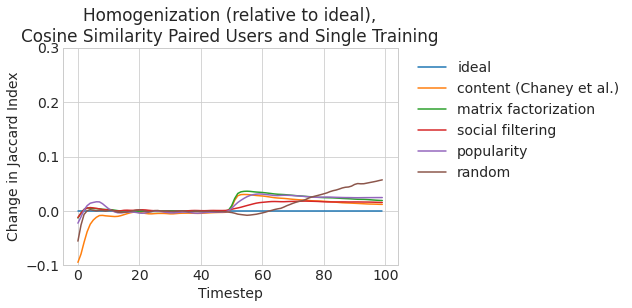

In [29]:
for m in model_keys:
    plt.plot(gaussian_filter1d(np.copy(relative_jaccard[m][:200]), sigma=sigma), label=id_to_readable[m])
plt.ylabel("Change in Jaccard Index")
plt.xlabel("Timestep")
plt.legend(facecolor='white', framealpha=1, loc='upper right', bbox_to_anchor=(1.7, 1.0))
plt.title("Homogenization (relative to ideal),\nCosine Similarity Paired Users and Single Training")
plt.ylim(-0.1, 0.3)
plt.savefig('single_training_sim_pair.pdf', bbox_inches = "tight")

# Diagnosing what's going on in the various simulations

In [33]:
# get change in jaccard index just for ideal recommender
single_train_ideal_jac = np.array(single_train_results["random_users"]["ideal"])
single_train_rel_jac = {}

for model_key in model_keys:
    abs_jaccard = np.array(single_train_results["random_users"][model_key])
    single_train_rel_jac[model_key] = (abs_jaccard - single_train_ideal_jac).mean(axis=0) # average across 10 trials
    
# get change in jaccard index just for ideal recommender
rep_train_ideal_jac = np.array(rep_train_results["random_users"]["ideal"])
rep_train_rel_jac = {}

for model_key in model_keys:
    abs_jaccard = np.array(rep_train_results["random_users"][model_key])
    rep_train_rel_jac[model_key] = (abs_jaccard - rep_train_ideal_jac).mean(axis=0) # average across 10 trials

In [39]:
single_ideal_jac_avg = single_train_ideal_jac[:, :STARTUP_ITERS].mean(axis=0)
rep_ideal_jac_avg = rep_train_ideal_jac[:, :STARTUP_ITERS].mean(axis=0)
print(single_ideal_jac_avg)
print(rep_ideal_jac_avg)
print(f"Differences between single and ideal: {single_ideal_jac_avg-rep_ideal_jac_avg}") # differences seems mall

[0.198      0.15433333 0.15635    0.14463333 0.13616071 0.13463658
 0.13507368 0.13556748 0.13021903 0.12874017 0.12677003 0.12552751
 0.1235328  0.1259007  0.12665436 0.12569083 0.12375999 0.12427252
 0.12634458 0.12813297 0.12795495 0.1277265  0.12691392 0.12781629
 0.12823168 0.12886175 0.12960242 0.13064672 0.13096672 0.1303035 ]
[0.21525    0.16291667 0.15925    0.1442     0.13969048 0.13784405
 0.13623355 0.13721924 0.13316115 0.12995591 0.12889698 0.12608451
 0.12461511 0.12653695 0.12655321 0.12557948 0.12345173 0.12431442
 0.12563106 0.12765318 0.12797078 0.12754948 0.12681282 0.12724924
 0.12738746 0.12829378 0.12883507 0.13011779 0.13049872 0.12944376]
Differences between single and ideal: [-1.72500000e-02 -8.58333333e-03 -2.90000000e-03  4.33333333e-04
 -3.52976190e-03 -3.20746753e-03 -1.15986791e-03 -1.65176490e-03
 -2.94211597e-03 -1.21574025e-03 -2.12694382e-03 -5.57005438e-04
 -1.08230310e-03 -6.36246846e-04  1.01148784e-04  1.11346723e-04
  3.08257977e-04 -4.18932065e-

# Troubleshooting

In [30]:
NUM_USERS = 3
NUM_ITEMS = 10 # 2 random for 2 iterations, then 2 new for 3 iterations
NUM_ATTRS = 2

users = np.around(np.random.rand(NUM_USERS, NUM_ATTRS), decimals=3)
items = np.around(np.random.rand(NUM_ATTRS, NUM_ITEMS), decimals=3)
true_scores = np.around(np.random.rand(NUM_USERS, NUM_ITEMS), decimals=3)
user_utils = np.copy(true_scores)
pairs = [np.random.choice(NUM_USERS, 2, replace=False) for _ in range(3)]

STARTUP_ITERS = 3
SIM_ITERS = 2 # TODO: CHANGE WHEN NOT TESTING
NEW_ITEMS_PER_ITER = 2
TOTAL_ITEMS_IN_STARTUP = NEW_ITEMS_PER_ITER * STARTUP_ITERS
ATTENTION_EXP = 0

init_params = {
    "num_items_per_iter": NEW_ITEMS_PER_ITER,
    "num_users": NUM_USERS,
    "num_items": 0, # all simulations start with 0 items
    "interleaving_fn": interleave_new_items
}

run_params = {
    "random_items_per_iter": NEW_ITEMS_PER_ITER,
    "vary_random_items_per_iter": False,
    "timesteps": SIM_ITERS,
}

In [31]:
print(f"Total items seen during training phase: {TOTAL_ITEMS_IN_STARTUP}")
print("User's preferred items (high to low)")
print((true_scores * -1).argsort(axis=1))
print()
print("User's training-set preferred items (high to low)")
print((true_scores * -1)[:, :TOTAL_ITEMS_IN_STARTUP].argsort(axis=1))
print()
print("User-item scores:")
print(true_scores)
print()
print("User profiles:")
print(users)
print()
print("Item profiles:")
print(items)

Total items seen during training phase: 6
User's preferred items (high to low)
[[2 0 7 1 5 3 6 9 8 4]
 [1 8 0 4 2 9 7 5 3 6]
 [9 3 7 2 6 1 0 4 8 5]]

User's training-set preferred items (high to low)
[[2 0 1 5 3 4]
 [1 0 4 2 5 3]
 [3 2 1 0 4 5]]

User-item scores:
[[0.74  0.417 0.753 0.309 0.162 0.32  0.285 0.673 0.185 0.213]
 [0.687 0.928 0.554 0.095 0.669 0.195 0.034 0.289 0.71  0.3  ]
 [0.2   0.216 0.781 0.817 0.153 0.086 0.227 0.786 0.138 0.875]]

User profiles:
[[0.668 0.263]
 [0.126 0.531]
 [0.946 0.438]]

Item profiles:
[[0.297 0.001 0.724 0.499 0.86  0.841 0.261 0.793 0.067 0.31 ]
 [0.69  0.657 0.275 0.477 0.32  0.124 0.556 0.328 0.973 0.591]]


In [32]:
u, item_factory, empty_items = initialize_users_and_items(true_scores, items)
ideal = IdealRecommender(
    user_representation=users,
    creators=item_factory, 
    actual_user_representation=u,
    actual_item_representation=empty_items,
    score_fn=perfect_scores_first_items(TOTAL_ITEMS_IN_STARTUP, true_scores),
#     verbose=True,
    **init_params
)
ideal.add_metrics(InteractionSimilarity(pairs), InteractionTracker())
ideal.startup_and_train(timesteps=STARTUP_ITERS)
ideal.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER) # show all items from training set plus interleaved itmes
ideal.run(**run_params)

ideal_interactions = np.hstack(process_measurement(ideal, "interaction_history")) # pull out the interaction history for the ideal simulations

100%|██████████| 2/2 [00:00<00:00, 1222.29it/s]


In [33]:
print(f"Total items seen during training phase: {TOTAL_ITEMS_IN_STARTUP}")
print("User's preferred items (high to low)")
print((true_scores * -1).argsort(axis=1))
print()
print("User's training-set preferred items (high to low)")
print((true_scores * -1)[:, :TOTAL_ITEMS_IN_STARTUP].argsort(axis=1))
print()
print("User-item scores:")
print(true_scores)
print()
print("User profiles:")
print(users)
print()
print("Item profiles:")
print(items)

Total items seen during training phase: 6
User's preferred items (high to low)
[[2 0 7 1 5 3 6 9 8 4]
 [1 8 0 4 2 9 7 5 3 6]
 [9 3 7 2 6 1 0 4 8 5]]

User's training-set preferred items (high to low)
[[2 0 1 5 3 4]
 [1 0 4 2 5 3]
 [3 2 1 0 4 5]]

User-item scores:
[[0.74  0.417 0.753 0.309 0.162 0.32  0.285 0.673 0.185 0.213]
 [0.687 0.928 0.554 0.095 0.669 0.195 0.034 0.289 0.71  0.3  ]
 [0.2   0.216 0.781 0.817 0.153 0.086 0.227 0.786 0.138 0.875]]

User profiles:
[[0.668 0.263]
 [0.126 0.531]
 [0.946 0.438]]

Item profiles:
[[0.297 0.001 0.724 0.499 0.86  0.841 0.261 0.793 0.067 0.31 ]
 [0.69  0.657 0.275 0.477 0.32  0.124 0.556 0.328 0.973 0.591]]


## Troubleshoot random recommender

In [34]:
u, item_factory, empty_items = initialize_users_and_items(true_scores, items)
r = RandomRecommender(
    creators=item_factory,
    actual_item_representation=empty_items, 
    actual_user_representation=u, 
    score_fn=random_score_first_n_items(TOTAL_ITEMS_IN_STARTUP),
    verbose=True,
    **init_params
)
r.add_metrics(SimilarUserInteractionSimilarity(ideal_interactions))
r.add_state_variable(r.users_hat)
r.startup_and_train(timesteps=STARTUP_ITERS)
r.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER)
r.run(train_between_steps=True, **run_params)


100%|██████████| 2/2 [00:00<00:00, 49.16it/s]


In [35]:
print(f"Total items seen during training phase: {TOTAL_ITEMS_IN_STARTUP}")
print("User's preferred items (high to low)")
print((true_scores * -1).argsort(axis=1))
print()
print("User's training-set preferred items (high to low)")
print((true_scores * -1)[:, :TOTAL_ITEMS_IN_STARTUP].argsort(axis=1))
print()
print("User-item scores:")
print(true_scores)
print()
print("User profiles:")
print(users)
print()
print("Item profiles:")
print(items)

Total items seen during training phase: 6
User's preferred items (high to low)
[[2 0 7 1 5 3 6 9 8 4]
 [1 8 0 4 2 9 7 5 3 6]
 [9 3 7 2 6 1 0 4 8 5]]

User's training-set preferred items (high to low)
[[2 0 1 5 3 4]
 [1 0 4 2 5 3]
 [3 2 1 0 4 5]]

User-item scores:
[[0.74  0.417 0.753 0.309 0.162 0.32  0.285 0.673 0.185 0.213]
 [0.687 0.928 0.554 0.095 0.669 0.195 0.034 0.289 0.71  0.3  ]
 [0.2   0.216 0.781 0.817 0.153 0.086 0.227 0.786 0.138 0.875]]

User profiles:
[[0.668 0.263]
 [0.126 0.531]
 [0.946 0.438]]

Item profiles:
[[0.297 0.001 0.724 0.499 0.86  0.841 0.261 0.793 0.067 0.31 ]
 [0.69  0.657 0.275 0.477 0.32  0.124 0.556 0.328 0.973 0.591]]


## Troubleshoot Chaney/MF recommender

In [33]:
u, item_factory, empty_items = initialize_users_and_items(true_scores, items)
initial_users_hat = np.random.rand(NUM_USERS, NUM_ATTRS)

chaney = ChaneyContent(
    creators=item_factory, 
    num_attributes=NUM_ATTRS,
    actual_item_representation=empty_items,
    user_representation=initial_users_hat,
    actual_user_representation=u,
    score_fn=freeze_scores_after_n_items(TOTAL_ITEMS_IN_STARTUP),
    verbose=True,
    **init_params)
chaney.add_metrics(SimilarUserInteractionSimilarity(ideal_interactions))
chaney.add_state_variable(chaney.users_hat)
chaney.startup_and_train(timesteps=STARTUP_ITERS) # update user representations, but only serve random items
chaney.set_num_items_per_iter(TOTAL_ITEMS_IN_STARTUP + NEW_ITEMS_PER_ITER) # show all items from training set plus interleaved itmes
chaney.run(train_between_steps=True, **run_params)

100%|██████████| 3/3 [00:00<00:00, 96.98it/s]


In [30]:
print(f"Total items seen during training phase: {TOTAL_ITEMS_IN_STARTUP}")
print("User's preferred items (high to low)")
print((true_scores * -1).argsort(axis=1))
print()
print("User's training-set preferred items (high to low)")
print((true_scores * -1)[:, :TOTAL_ITEMS_IN_STARTUP].argsort(axis=1))
print()
print("User-item scores:")
print(true_scores)
print()
print("User profiles:")
print(users)
print()
print("Item profiles:")
print(items)

Total items seen during training phase: 4
User's preferred items (high to low)
[[7 0 2 4 1 6 3 8 5 9]
 [9 7 1 3 8 2 4 0 6 5]
 [7 0 9 6 2 1 8 4 5 3]]

User's training-set preferred items (high to low)
[[0 2 1 3]
 [1 3 2 0]
 [0 2 1 3]]

User-item scores:
[[0.773 0.622 0.728 0.386 0.666 0.175 0.577 0.871 0.308 0.131]
 [0.35  0.637 0.514 0.603 0.479 0.017 0.029 0.885 0.55  0.93 ]
 [0.903 0.453 0.519 0.085 0.313 0.168 0.771 0.962 0.376 0.848]]

User profiles:
[[0.305 0.291]
 [0.019 0.318]
 [0.439 0.345]]

Item profiles:
[[0.925 0.691 0.303 0.361 0.866 0.322 0.502 0.359 0.777 0.484]
 [0.371 0.113 0.594 0.684 0.087 0.202 0.674 0.318 0.153 0.238]]
